## Neural Networks with Back Propogation

## Importing Packages

In [ ]:
#Import packages
import numpy as np
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from random import seed
from random import random
from random import randrange

## Reading CSV Data File

In [ ]:
#Read data and add feature names
dataset = pd.read_csv('data_banknote_authentication.txt',names=['variance','skewness','curtosis','entropy','class'])

### Printing Dataset Information

In [ ]:
#Check info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [ ]:
#Check header
dataset.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Data Preprocessing

Involes renaming columns and normalizing the data.

In [ ]:
# Data-preprocessing
#Define training features in X
X = dataset[['variance','skewness','curtosis','entropy']]
#Define output target feature in Y
Y = dataset[['class']]

In [ ]:
#Standardize numerical features of X
X = (X-np.mean(X))/np.std(X)

In [ ]:
#Add bias feature in X
#X['bias'] = np.ones(len(Y))

## Generating Datasets for Training, Testing and Validation

In [ ]:
#Create Train (including validate) and Test sets
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, train_size=0.8, random_state=101)
#Create Train and Validate sets
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_full, Y_train_full, train_size=0.2, random_state=101)

In [ ]:
total_features = len(X_train.columns)

In [ ]:
# Calculate weighted sum of input features for a neuron
def getWeightedSum(weights, inputs):
	weightedSum = weights[-1]
	for i in range(len(weights)-1):
		weightedSum += weights[i] * inputs[i]
	return weightedSum

In [ ]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

In [ ]:
# Signmod activation
def getSigmoid(weightedSum):
	return 1.0 / (1.0 + np.exp(-weightedSum))

In [ ]:
# Sigmoid derivative
def getSigmoidDerivative(sigmoid_output):
	return sigmoid_output * (1.0 - sigmoid_output)

In [ ]:
# Hyperbolic tangent Activation
def getHyperTangent(weightedSum):
  return (np.exp(weightedSum) - np.exp(-weightedSum))/(np.exp(weightedSum) + np.exp(-weightedSum))

In [ ]:
# Hyperbolic tangent Derivative
def getHypTanDerivative(tanh_output):
  return 1.0 - tanh_output * tanh_output

In [ ]:
#Defining Threshold Function for changing threshold, based on activation function
def define_threshold(activation_func):
  act_func = str(activation_func)
  l, h = None, None
  if 'getSigmoid' in act_func:
    l, h= 0.25, 0.75
  elif 'getHyperTangent' in act_func:
    l, h = -0.5, 0.5
  else:
    l, h = None, None
  return l, h

In [ ]:
#Defining output labels, based on the activation function
def define_output(act_function):
  act_func = str(act_function)
  l, h = None, None
  if 'getSigmoid' in act_func:
    l, h= 0, 1
  elif 'getHyperTangent' in act_func:
    l, h = -1, 1
  else:
    l, h = None, None
  return l, h

In [ ]:
# Forward propagate input to a network output
def forward_propagate(network, feature_inputs,activation_function=getSigmoid):
	inputs = feature_inputs
	l, h = define_threshold(activation_function)
	l_out, h_out = define_output(activation_function)
	for layer in network:
		new_inputs = []
		for neuron in layer:
			weightedSum = getWeightedSum(neuron['weights'], inputs)
			neuron['output'] = activation_function(weightedSum)
			if neuron['output'] >= h:
				neuron['output'] = h_out
			elif neuron['output'] <= l:
				neuron['output'] = l_out
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs

In [ ]:
# Initialize Weights
def getInitialWeights(feature_count):
    limit = np.sqrt(3/feature_count)
    initialWeights = np.random.uniform(-limit, limit,feature_count)
    return initialWeights

In [ ]:
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected, activation_derivative_function=getSigmoidDerivative):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(neuron['output'] - expected)
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * activation_derivative_function(neuron['output'])

In [ ]:
# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] -= l_rate * neuron['delta']

In [ ]:
# Train a network for a fixed number of epochs
def train_network(network, x, y, eta=0.1, epochs=50, activation_function=getSigmoid, activation_derivative_function=getSigmoidDerivative):
	for epoch in range(epochs):
		for data_point, expected in zip(x, y):
			outputs = forward_propagate(network, data_point, activation_function)
			backward_propagate_error(network, expected, activation_derivative_function)
			update_weights(network, data_point, eta)

In [ ]:
# Initialize a network
def initialize_network(n_inputs=total_features, n_hidden=total_features, n_outputs=1, init_weights=None):
	network = list()
	if init_weights:
		hidden_layer = [{'weights': init_weights[0][i]} for i in range(n_hidden)]	
		output_layer = [{'weights': init_weights[1][i]} for i in range(n_outputs)]	
	else:
		hidden_layer = [{'weights':getInitialWeights(n_inputs+1)} for i in range(n_hidden)]
		output_layer = [{'weights':getInitialWeights(n_hidden+1)} for i in range(n_outputs)]
	network.append(hidden_layer)
	network.append(output_layer)
	return network

In [ ]:
# Make a prediction with a network
def predict(network, row, activation_function):
	outputs = forward_propagate(network, row,activation_function)
	return outputs[-1]

In [ ]:
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(x_train,y_train,x_test,y_test, eta=0.1, epochs=50, 
                     n_hidden = total_features,
										 activation_function=getSigmoid,activation_derivative_function=getSigmoidDerivative, 
										 init_weights=None):
	n_inputs = len(x_train[0])
	n_outputs = len(y_train[0])
	network = initialize_network(n_inputs, n_hidden, n_outputs, init_weights)
	train_network(network,x_train,y_train,eta,epochs,activation_function,activation_derivative_function)
	predictions = list()
	for row in x_test:
		prediction = predict(network, row,activation_function)
		predictions.append(prediction)	
	return(accuracy_metric(y_test,predictions))

#### Defining X, Y Matrices

In [ ]:
#Initializing matrices of the training, testing and validation sets
X_train_mat = X_train.to_numpy()
Y_train_mat = Y_train.to_numpy()

X_test_mat = X_test.to_numpy()
Y_test_mat = Y_test.to_numpy()

X_valid_mat = X_valid.to_numpy()
Y_valid_mat = Y_valid.to_numpy()

#Transformation in data for Tanh Function
Y_train_tanh = Y_train.copy()
Y_train_tanh['class'] = Y_train_tanh['class'].apply(lambda y: -1 if y == 0 else 1)
Y_valid_tanh = Y_valid.copy()
Y_valid_tanh['class'] = Y_valid_tanh['class'].apply(lambda y: -1 if y == 0 else 1)
Y_test_tanh = Y_test.copy()
Y_test_tanh['class'] = Y_test_tanh['class'].apply(lambda y: -1 if y == 0 else 1)
Y_train_mat_tanh = Y_train_tanh.to_numpy()
Y_valid_mat_tanh = Y_valid_tanh.to_numpy()
Y_test_mat_tanh = Y_test_tanh.to_numpy()

#### Initializing new weights

In [ ]:
# Function to get initialiized weights for comparison
def getInitializedWeights(n_inputs=total_features, n_hidden=total_features, n_outputs=1):
  weights = []
  # Initializing Weights for hidden layer
  weights.append([getInitialWeights(n_inputs+1) for i in range(n_hidden)])
  weights.append([getInitialWeights(n_hidden+1) for i in range(n_outputs)])
  return weights

### Testing for best Activation Function

Testing for Activation Functions:

1.   Sigmoid Function
2.   Hyperbolic Tangent Function



Result on Eta: 0.01
	Accuracy of activation function <function getSigmoid at 0x7fa90332f0e0> of with 4 hidden neurons is 87.58542141230068%
	Accuracy of activation function <function getHyperTangent at 0x7fa9033a9320> of with 4 hidden neurons is 97.83599088838268%
Result on Eta: 0.02
	Accuracy of activation function <function getSigmoid at 0x7fa90332f0e0> of with 4 hidden neurons is 92.48291571753985%
	Accuracy of activation function <function getHyperTangent at 0x7fa9033a9320> of with 4 hidden neurons is 93.50797266514806%
Result on Eta: 0.03
	Accuracy of activation function <function getSigmoid at 0x7fa90332f0e0> of with 4 hidden neurons is 93.84965831435079%
	Accuracy of activation function <function getHyperTangent at 0x7fa9033a9320> of with 4 hidden neurons is 97.38041002277905%
Result on Eta: 0.04
	Accuracy of activation function <function getSigmoid at 0x7fa90332f0e0> of with 4 hidden neurons is 93.96355353075171%
	Accuracy of activation function <function getHyperTangent at 0x7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


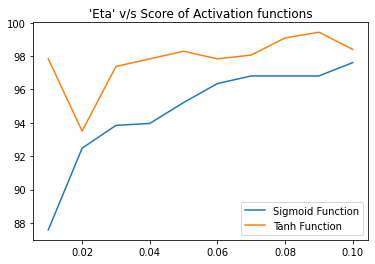

In [ ]:
# Setup
epochs = 500
n_hidden = 4

func = [(getSigmoid, getSigmoidDerivative, Y_train_mat, Y_valid_mat), (getHyperTangent, getHypTanDerivative, Y_train_mat_tanh, Y_valid_mat_tanh)]
#Run on Validation set with different activation functions to get the best function
best_scores = { 'Eta': [], 'Sigmoid': [], 'Tanh': [], 'best_func': []}
eta_s = np.arange(0.01, 0.11, 0.01)
for eta in eta_s:
  print(f"Result on Eta: {eta}")
  scores = [] 
  for activation, activation_derivative, y_t, y_v in func:
    score = back_propagation(X_train_mat,y_t,X_valid_mat,y_v, eta, epochs, n_hidden,activation, activation_derivative)
    scores.append(score)
    print(f'\tAccuracy of activation function {activation} of with {n_hidden} hidden neurons is {score}%')

  # Evaluating the best activation function 
  max_score = max(scores)
  best_func = func[scores.index(max_score)]
  # print(f'\nThe activation function {best_func[0]} has the best score: {max_score}%')
  best_scores['Eta'].append(eta)
  best_scores['Sigmoid'].append(scores[0])
  best_scores['Tanh'].append(scores[1])
  best_scores['best_func'].append(best_func)

sig_scores = []
tanh_scores= []
for tanh_score, sig_score in zip(best_scores['Tanh'], best_scores['Sigmoid']):
  sig_scores.append(sig_score)
  tanh_scores.append(tanh_score)

plt.title("'Eta' v/s Score of Activation functions")
plt.plot(eta_s, sig_scores,  label ="Sigmoid Function")
plt.plot(eta_s, tanh_scores,  label ="Tanh Function")
plt.xlabel("Learning Rate (eta) ->")
plt.ylabel("Accuracy of the Neural Network ->")
plt.legend(loc="lower right")
plt.show()



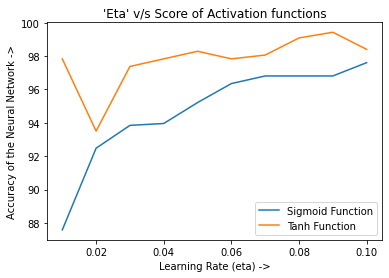

In [ ]:
plt.title("'Eta' v/s Score of Activation functions")
plt.plot(eta_s, sig_scores,  label ="Sigmoid Function")
plt.plot(eta_s, tanh_scores,  label ="Tanh Function")
plt.xlabel("Learning Rate (eta) ->")
plt.ylabel("Accuracy of the Neural Network ->")
plt.legend(loc="lower right")
plt.show()

In [ ]:
## Evaluating Squashing Function
# Taking Max out of DataFrames
scores_df = pd.DataFrame(best_scores)
max_scores_df = scores_df.max()

if max_scores_df['Sigmoid'] > max_scores_df['Tanh']:
  max_df = scores_df[scores_df['Sigmoid'] == max_scores_df['Sigmoid']]
  best_eta = max_df['Eta']
  best_squashing_func = (getSigmoid, getSigmoidDerivative)
else:
  max_df = scores_df[scores_df['Tanh'] == max_scores_df['Tanh']]
  best_eta = max_df['Eta']
  best_squashing_func = (getHyperTangent, getHypTanDerivative)

In [ ]:
# Setup
eta = best_eta

# Selecting best activation function
activation = best_squashing_func[0]
act_derivative = best_squashing_func[1]

#Run on Validation set with different hidden neurons till 1 and get best accuracy
scores = { 'hidden_neurons': [], 'score': []}
for n_hidden in range(4, 0,-1):
  weights = getInitializedWeights(len(X_train_mat[0]), n_hidden, len(Y_train_mat_tanh[0]))
  score = back_propagation(X_train_mat, Y_train_mat_tanh, X_valid_mat, Y_valid_mat_tanh, eta, epochs, n_hidden, activation, act_derivative, weights)
  scores['hidden_neurons'].append(n_hidden)
  scores['score'].append(score)
  print(f'Accuracy with {n_hidden} hidden neurons is {score}%')


Accuracy with 4 hidden neurons is 97.26651480637814%
Accuracy with 3 hidden neurons is 98.40546697038725%
Accuracy with 2 hidden neurons is 97.83599088838268%
Accuracy with 1 hidden neurons is 97.15261958997722%


#### Selecting the best Scores

In [ ]:
scores_df = pd.DataFrame(scores)
best_scores_df = scores_df[scores_df['score'] == scores_df['score'].max()]
best_hidden_neurons = int(best_scores_df.iloc[0]['hidden_neurons'])
print(f"The best number of neurons for the hidden layer is '{best_hidden_neurons}'")

The best number of neurons for the hidden layer is '3'


#### Train the network on best parameters found.


In [ ]:
# Final Parameters
eta = best_eta
n_hidden = best_hidden_neurons

# Selecting best activation function
activation = best_squashing_func[0]
act_derivative = best_squashing_func[1]

#Train on best neural network and test on it
score = back_propagation(X_train_mat, Y_train_mat_tanh, X_test_mat, Y_test_mat_tanh, eta, epochs, n_hidden, activation, act_derivative)
print(f'Accuracy with {n_hidden} hidden neurons is {score}%')

Accuracy with 3 hidden neurons is 99.63636363636364%
